# COLIEE 2024 Dataset Exploration


In [1]:
from pathlib import Path
import json, random, textwrap
import pandas as pd
import re, itertools

In [6]:
# Use Training Dataset or Test dataset 
# DATASET_DIR  = Path("Test/Dataset")
# LABELS_FILE  = DATASET_DIR / "task1_test_labels_2025.json"
# CASES_DIR    = DATASET_DIR / "task1_test_files_2025"

DATASET_DIR  = Path("Dataset")
LABELS_FILE  = DATASET_DIR / "task1_train_labels_2025.json"
CASES_DIR    = DATASET_DIR / "task1_train_files_2025"

## 1.  Basic paths – edit here only if your folder names differ


In [7]:


assert LABELS_FILE.exists(),  "Labels file not found – check your path"
assert CASES_DIR.exists(),    "Cases directory not found – check your path"

## 2.  Load labels → tidy DataFrame


In [8]:
with LABELS_FILE.open(encoding="utf-8") as f:
    raw_labels = json.load(f)

records = [
    {"query_id": q, "num_citations": len(supp), "citations": supp}
    for q, supp in raw_labels.items()
]
labels_df = pd.DataFrame(records).sort_values("query_id").reset_index(drop=True)

print(f"Loaded {len(labels_df):,} query cases")
display(labels_df.head())

Loaded 1,678 query cases


,query_id,num_citations,citations
0,000002.txt,2,"[098736.txt, 078781.txt]"
1,000031.txt,9,"[074681.txt, 013059.txt, 087019.txt, 070067.tx..."
2,000068.txt,9,"[015824.txt, 067903.txt, 058390.txt, 030257.tx..."
3,000085.txt,3,"[047032.txt, 038007.txt, 061172.txt]"
4,000092.txt,7,"[085296.txt, 040661.txt, 055972.txt, 093174.tx..."


In [12]:
# Quick count of all query–candidate pairs
total_pairs = int(labels_df["num_citations"].sum())
print(f"Total query–candidate pairs: {total_pairs:,}")

# Optional: make a flat (query_id, candidate_id) table
pairs_df = (
    labels_df[["query_id", "citations"]]
    .explode("citations", ignore_index=True)
    .rename(columns={"citations": "candidate_id"})
    .dropna()
    .drop_duplicates()
)

# Sanity check for your example
ex = "000068.txt"
if ex in labels_df["query_id"].values:
    n = pairs_df.query("query_id == @ex").shape[0]
    print(f"{ex} -> {n} query–candidate pairs")

# peek
pairs_df.head()


Total query–candidate pairs: 6,881
000068.txt -> 9 query–candidate pairs


,query_id,candidate_id
0,000002.txt,098736.txt
1,000002.txt,078781.txt
2,000031.txt,074681.txt
3,000031.txt,013059.txt
4,000031.txt,087019.txt


## Quick summary statistics


In [5]:
print("\n--- Label statistics ----------------------------------")
print(labels_df["num_citations"].describe())


--- Label statistics ----------------------------------
count    400.000000
mean       4.397500
std        3.317682
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       25.000000
Name: num_citations, dtype: float64


In [6]:
from collections import Counter
import pandas as pd

# Flatten the list of all cited cases
all_cited_cases = list(itertools.chain.from_iterable(labels_df["citations"]))

# Count each citation's frequency
citation_counts = Counter(all_cited_cases)

# Convert to DataFrame for inspection/sorting
citation_df = pd.DataFrame(citation_counts.items(), columns=["case_id", "count"])
citation_df = citation_df.sort_values("count", ascending=False).reset_index(drop=True)

print(f"\nTotal unique cited cases: {len(citation_df):,}")
display(citation_df.head(10))  # top 10 most-cited cases

display(citation_df.tail(10))  # top 10 most-cited cases



Total unique cited cases: 1,759


,case_id,count
0,031244.txt,1
1,062645.txt,1
2,040250.txt,1
3,021343.txt,1
4,013794.txt,1
5,012826.txt,1
6,015542.txt,1
7,059632.txt,1
8,063269.txt,1
9,021030.txt,1


,case_id,count
1749,038422.txt,1
1750,072568.txt,1
1751,088202.txt,1
1752,057221.txt,1
1753,071669.txt,1
1754,098083.txt,1
1755,049660.txt,1
1756,076100.txt,1
1757,024716.txt,1
1758,082597.txt,1


In [7]:
# 1. Get set of query IDs (strip .txt if needed)
query_ids = set(labels_df["query_id"])

# 2. Get set of cited case IDs
cited_ids = set(citation_df["case_id"])

# 3. Union of all used case IDs
used_case_ids = query_ids.union(cited_ids)

# 4. List all .txt files in the CASES_DIR
all_case_files = {p.name for p in CASES_DIR.glob("*.txt")}

# 5. Find unused files (not in labels or citations)
unused_cases = all_case_files - used_case_ids

# Show results
print(f"\nTotal case files on disk: {len(all_case_files):,}")
print(f"Cases used in labels (query or cited): {len(used_case_ids):,}")
print(f"Unused cases (not referenced in labels): {len(unused_cases):,}")
print("\nSample of unused cases:")
display(list(sorted(unused_cases))[:10])



Total case files on disk: 2,159
Cases used in labels (query or cited): 2,159
Unused cases (not referenced in labels): 0

Sample of unused cases:


[]

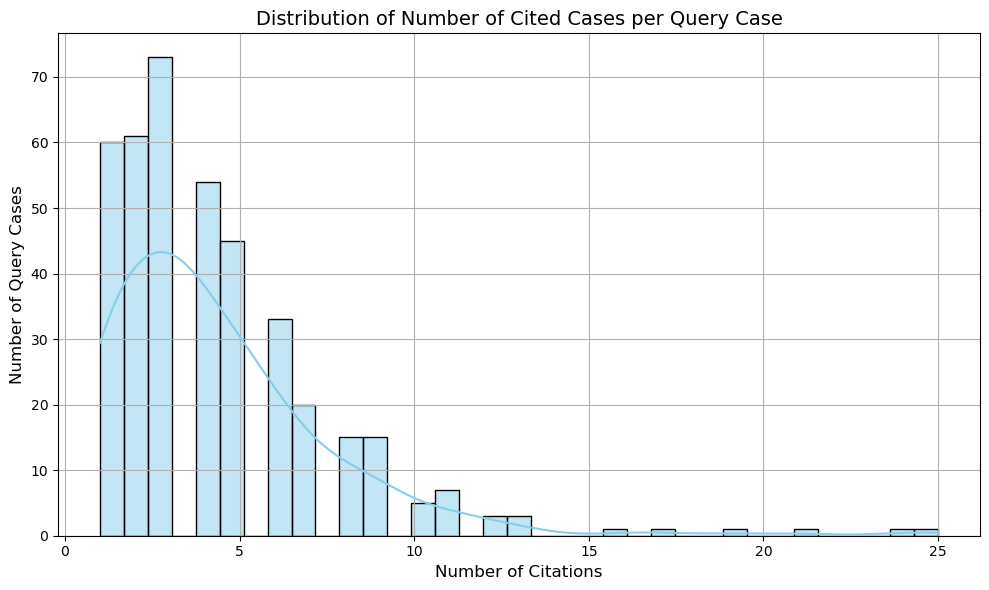

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic setup
plt.figure(figsize=(10, 6))
sns.histplot(labels_df["num_citations"], bins=35, kde=True, color="skyblue", edgecolor="black")

# Titles and labels
plt.title("Distribution of Number of Cited Cases per Query Case", fontsize=14)
plt.xlabel("Number of Citations", fontsize=12)
plt.ylabel("Number of Query Cases", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


## 3.  Tiny helpers to read / preview case files


In [6]:
def read_case(doc_id: str) -> str:
    """Return full text of a single COLIEE case (UTF-8)."""
    p = CASES_DIR / doc_id
    if not p.exists():
        raise FileNotFoundError(p)
    return p.read_text(encoding="utf-8", errors="ignore")

def preview_case(doc_id: str, lines: int = 25):
    """Pretty-print the first N lines of a case file."""
    txt = read_case(doc_id)
    snippet = "\n".join(txt.splitlines()[:lines])
    print("="*80, f"\n{doc_id}  (first {lines} lines)\n", "="*80)
    print(snippet)

# Example: look at the first query document
preview_case(labels_df.loc[0, "query_id"], 50)

000002.txt  (first 50 lines)
[1]
Bédard, J.
[Translation]: This is an application for judicial review under subsection 72(1) of the
Immigration and Refugee Protection
Act
, S.C. 2001, c. 27 (the
Act
), of a decision of the Immigration Appeal Division of the Immigration and Refugee Board of Canada (the IAD), dated February 5, 2010, dismissing the applicant's appeal of a decision of the immigration officer of the Canadian Embassy in Abidjan, rejecting his application for permanent residence under the family class for the Cameroonian applicant's three adoptive children.
Background
[2]
The applicant is a Canadian citizen from Cameroon. On October 16, 2006, by a judgment of the court of first instance in Douala, he adopted, through a process of simple adoption, the three children of his friend who had died in 2003. The three children were born to two different mothers.
[3]
On April 2008, the applicant took steps to sponsor and obtain visas for the three children for permanent residence in C

## 4.  Lightweight keyword / regex search over the corpus


In [9]:
def search(keyword: str, max_hits: int = 10, regex=False):
    """
    Return list of (doc_id, line_no, line_text) for the first max_hits matches.
    Set regex=True to interpret the keyword as a regular expression.
    """
    pattern = re.compile(keyword if regex else re.escape(keyword), re.I)
    hits = []
    for txt_path in itertools.islice(CASES_DIR.glob("*.txt"), None):
        for i, line in enumerate(txt_path.open(encoding="utf-8", errors="ignore")):
            if pattern.search(line):
                hits.append((txt_path.name, i+1, line.strip()))
                if len(hits) >= max_hits:
                    return hits
    return hits

# Example: find “procedural fairness” mentions
for doc, ln, line in search("procedural fairness", max_hits=5):
    print(f"{doc:>12} : {ln:>4} | {textwrap.shorten(line, 80)}")

  000091.txt :   38 | The applicant further submits that the visa officer's failure to put her [...]
  000091.txt :   92 | In my view, the applicant failed to establish that the visa officer erred [...]
  000423.txt :   65 | A question as to whether there was a breach of the duty of procedural [...]
  000423.txt :   70 | As he conceded before this court, the Appeal Division was entitled to [...]
  001003.txt :   56 | The sole issue in this application is whether Transport Canada breached [...]


## 5.  Random visual sanity-check – peek at 3 query/support sets


In [10]:
for _, row in labels_df.sample(3, random_state=42).iterrows():
    print("\n","="*100)
    print(f"QUERY: {row.query_id}  →  {row.num_citations} cited cases")
    print("Citations:", ", ".join(row.citations))
    print("- Preview of query case:")
    preview_case(row.query_id, lines=12)


QUERY: 095201.txt  →  1 cited cases
Citations: 068653.txt
- Preview of query case:
095201.txt  (first 12 lines)
[1]
Hansen, J.
: The applicant, Zhu Xian Chen, seeks judicial review of the decision of Post Claim Determination Officer Neeta Sandhu (the "PCDO"), dated July 5, 2000. The PCDO determined that the applicant was not a member of the Post-Determination Refugee Claimants in Canada ("PDRCC") class.
[2]
The relevant facts can be summarized briefly. The applicant fled the Peoples Republic of China ("PRC") by boat on July 29, 1999. She was one of a number of individuals who arrived on the shores of British Columbia from the Fujian province of China in the summer of 1999. The applicant's Convention refugee claim was rejected on March 23, 2000. The applicant subsequently applied for consideration as a member of the PDRCC class.
[3]
The applicant's submissions state that she faces a potential risk to her life, inhumane treatment or extreme sanctions if returned to the PRC because she i

Processing cases:   0%|          | 0/2159 [00:00<?, ?it/s]

Processing cases: 100%|██████████| 2159/2159 [01:21<00:00, 26.47it/s]


--- Case File Statistics Summary ---


,num_words,num_sentences,avg_sentence_length,vocab_size
count,2159.000000,2159.000000,2159.000000,2159.000000
mean,5227.895785,225.797128,23.399054,1092.498379
std,5687.565114,257.913090,4.700994,635.685783
min,281.000000,12.000000,10.768421,147.000000
25%,2281.000000,104.000000,20.026334,684.500000
50%,3791.000000,162.000000,23.231417,946.000000
75%,6211.000000,254.000000,26.424130,1331.000000
max,113337.000000,5007.000000,45.445596,7483.000000


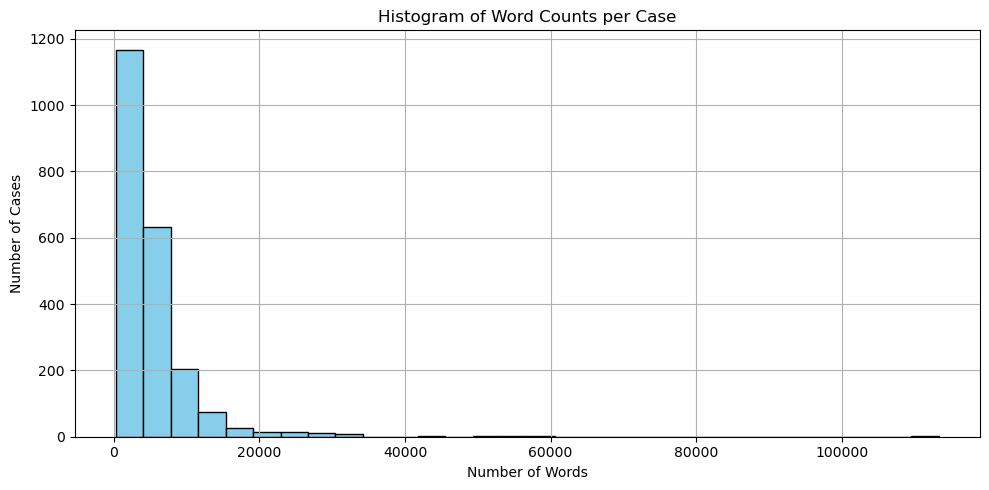

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

def get_case_statistics(case_dir: Path, max_files=None):
    stats = []
    file_list = list(case_dir.iterdir())
    if max_files:
        file_list = file_list[:max_files]
    
    for path in tqdm(file_list, desc="Processing cases"):
        text = path.read_text(encoding="utf-8", errors="ignore")
        words = re.findall(r"\b\w+\b", text)
        sentences = re.split(r"[.!?]\s+", text)
        paragraphs = text.split("\n\n")
        
        stats.append({
            "doc_id": path.name,
            "num_words": len(words),
            "num_sentences": len(sentences),
            #"num_paragraphs": len(paragraphs),
            "avg_sentence_length": len(words)/len(sentences) if sentences else 0,
            "vocab_size": len(set(words)),
        })
    
    return pd.DataFrame(stats)

# Run on all (or set max_files=N for faster preview)
case_stats_df = get_case_statistics(CASES_DIR)

# Summary statistics
print("\n--- Case File Statistics Summary ---")
display(case_stats_df.describe())

# Plot histogram of word counts
plt.figure(figsize=(10, 5))
plt.hist(case_stats_df["num_words"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Word Counts per Case")
plt.xlabel("Number of Words")
plt.ylabel("Number of Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
print("\nLongest cases:")
display(case_stats_df.sort_values("num_words", ascending=False).head(3))

print("\nShortest cases:")
display(case_stats_df.sort_values("num_words", ascending=True).head(3))



Longest cases:


,doc_id,num_words,num_sentences,avg_sentence_length,vocab_size
1249,057368.txt,113337,5007,22.635710,7483
2084,096334.txt,59380,1956,30.357873,4842
2107,097676.txt,56057,2562,21.880172,4387



Shortest cases:


,doc_id,num_words,num_sentences,avg_sentence_length,vocab_size
1798,082924.txt,281,17,16.529412,154
1941,089560.txt,281,17,16.529412,154
323,014790.txt,286,18,15.888889,147


Analyzing cases: 100%|██████████| 6835/6835 [00:00<00:00, 9288.65it/s]


--- Paragraph Statistics Summary ---


,num_paragraphs,avg_words_per_paragraph,avg_chars_per_paragraph,total_words,total_chars
count,6835.000000,6835.000000,6835.000000,6835.000000,6835.000000
mean,45.784931,98.738026,611.866753,4477.044331,27695.080907
std,44.385826,33.737984,208.139692,4627.473259,28249.517977
min,2.000000,29.090909,179.090909,102.000000,593.000000
25%,23.000000,76.029630,470.673614,2097.500000,12966.500000
50%,36.000000,92.342466,573.927536,3418.000000,21258.000000
75%,55.000000,114.500000,710.961538,5348.500000,33192.500000
max,998.000000,375.909091,2256.545455,107931.000000,645022.000000


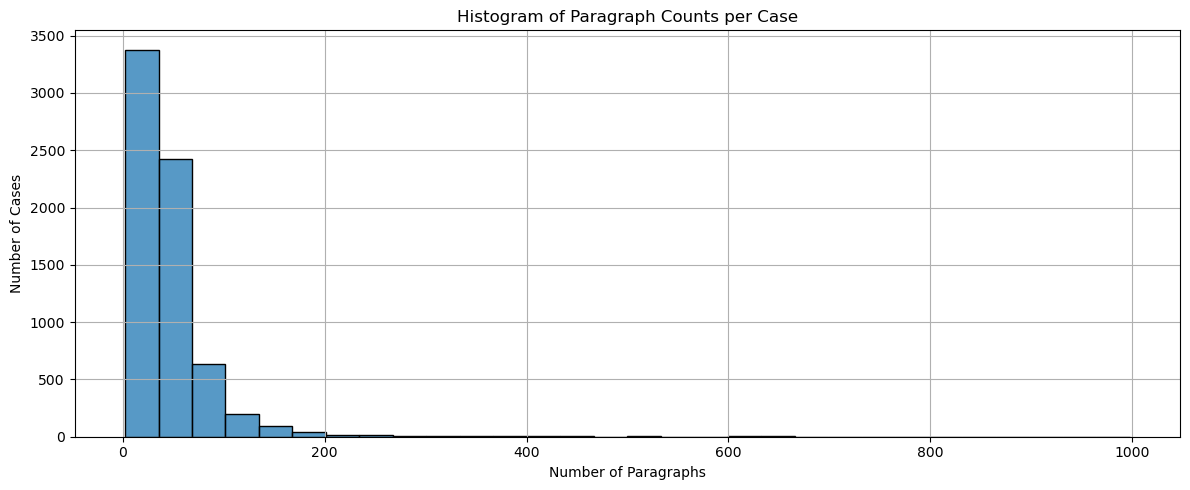

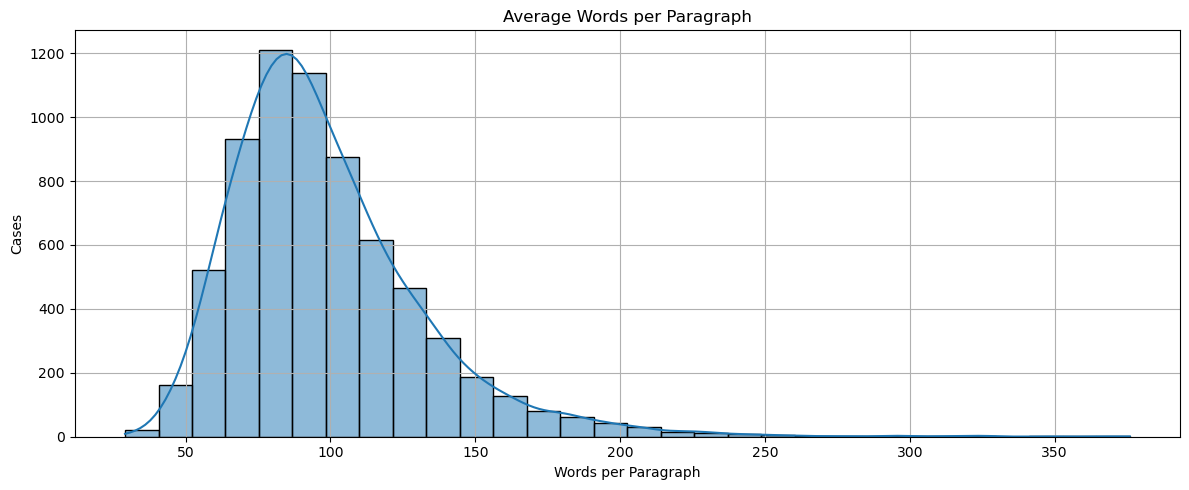

In [16]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Path to the processed JSON
JSON_FILE = Path("Dataset-Clean/processed_cases.json")

# Load JSON content
with JSON_FILE.open(encoding="utf-8") as f:
    cases = json.load(f)

# Extract paragraph-level statistics
records = []
for case in tqdm(cases, desc="Analyzing cases"):
    paragraphs = case.get("paragraphs", [])
    para_lengths = [len(p.split()) for p in paragraphs]
    para_char_lengths = [len(p) for p in paragraphs]

    records.append({
        "case_id": case["case_id"],
        "num_paragraphs": len(paragraphs),
        "avg_words_per_paragraph": sum(para_lengths)/len(paragraphs) if paragraphs else 0,
        "avg_chars_per_paragraph": sum(para_char_lengths)/len(paragraphs) if paragraphs else 0,
        "total_words": sum(para_lengths),
        "total_chars": sum(para_char_lengths),
    })

df_stats = pd.DataFrame(records)

# Summary
print("\n--- Paragraph Statistics Summary ---")
display(df_stats.describe())

# Histograms
plt.figure(figsize=(12, 5))
sns.histplot(df_stats["num_paragraphs"], bins=30, kde=False)
plt.title("Histogram of Paragraph Counts per Case")
plt.xlabel("Number of Paragraphs")
plt.ylabel("Number of Cases")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_stats["avg_words_per_paragraph"], bins=30, kde=True)
plt.title("Average Words per Paragraph")
plt.xlabel("Words per Paragraph")
plt.ylabel("Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
print("\nTop 5 cases with most paragraphs:")
display(df_stats.sort_values("num_paragraphs", ascending=False).head())

print("\nTop 5 cases with fewest paragraphs:")
display(df_stats.sort_values("num_paragraphs", ascending=True).head())



Top 5 cases with most paragraphs:


,case_id,num_paragraphs,avg_words_per_paragraph,avg_chars_per_paragraph,total_words,total_chars
3951,055641,998,72.645291,452.044088,72463,451809
5494,078607,884,101.531674,612.917421,90559,547700
990,014338,660,163.531818,977.306061,108746,650505
5722,082096,645,94.680620,574.178295,61065,370958
2820,039093,632,80.458861,502.960443,51214,320765



Top 5 cases with fewest paragraphs:


,case_id,num_paragraphs,avg_words_per_paragraph,avg_chars_per_paragraph,total_words,total_chars
5268,075466,2,51.000000,296.500000,102,594
2418,033670,3,76.333333,489.000000,228,1465
599,008378,3,104.000000,613.333333,312,1842
3247,044952,3,46.333333,286.666667,139,862
2675,037357,4,75.750000,418.250000,303,1676
